In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


In [38]:
import os
import json

path="experiments_gan"
results = []
for el in os.listdir(path):
    if el.endswith("json"):
        with open(path+"/"+el) as f:
            report = json.load(f)
            report["filename"] = el
            results.append(report)


res_df = pd.json_normalize(results, sep='.')
res_df["iters"] = res_df["trajectory"].apply(len)
res_df = res_df.sort_values(by=['run'])
res_df

,experiment_name,run,trajectory,best_loss_g,best_loss_d,filename,iters
1,simple_conv_gan,1,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3863...",0.693147,0.693147,simpleconvgan_1_report.json,11850
2,simple_conv_gan,2,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3875...",0.693147,0.693147,simpleconvgan_2_report.json,11850
3,simple_conv_gan,3,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3904...",0.777475,0.653822,simpleconvgan_3_report.json,11850
4,simple_conv_gan,4,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3869...",0.693147,0.693147,simpleconvgan_4_report.json,11850
5,simple_conv_gan,5,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3859...",0.693147,0.693147,simpleconvgan_5_report.json,11850
6,simple_conv_gan,6,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3894...",0.693147,0.693147,simpleconvgan_6_report.json,11850
7,simple_conv_gan,7,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3893...",0.693147,0.693147,simpleconvgan_7_report.json,11850
8,simple_conv_gan,8,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3856...",0.693147,0.693147,simpleconvgan_8_report.json,11850
9,simple_conv_gan,9,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3861...",0.693147,0.693147,simpleconvgan_9_report.json,11850
0,simple_conv_gan,10,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3853...",0.693147,0.693147,simpleconvgan_10_report.json,11850


In [52]:
def plot_run(traj, run, ax):
    d_losses = []
    g_losses = []
    for tr in traj:
        d_losses.append(tr['d_loss'])
        g_losses.append(tr['g_loss'])
    ax.plot(d_losses, label='d losses', linewidth=5)
    ax.plot(g_losses, label='g losses', linewidth=5)
    ax.set_title(run, size=25)
    ax.tick_params(axis='both', labelsize=20)
    ax.legend(fontsize=20)

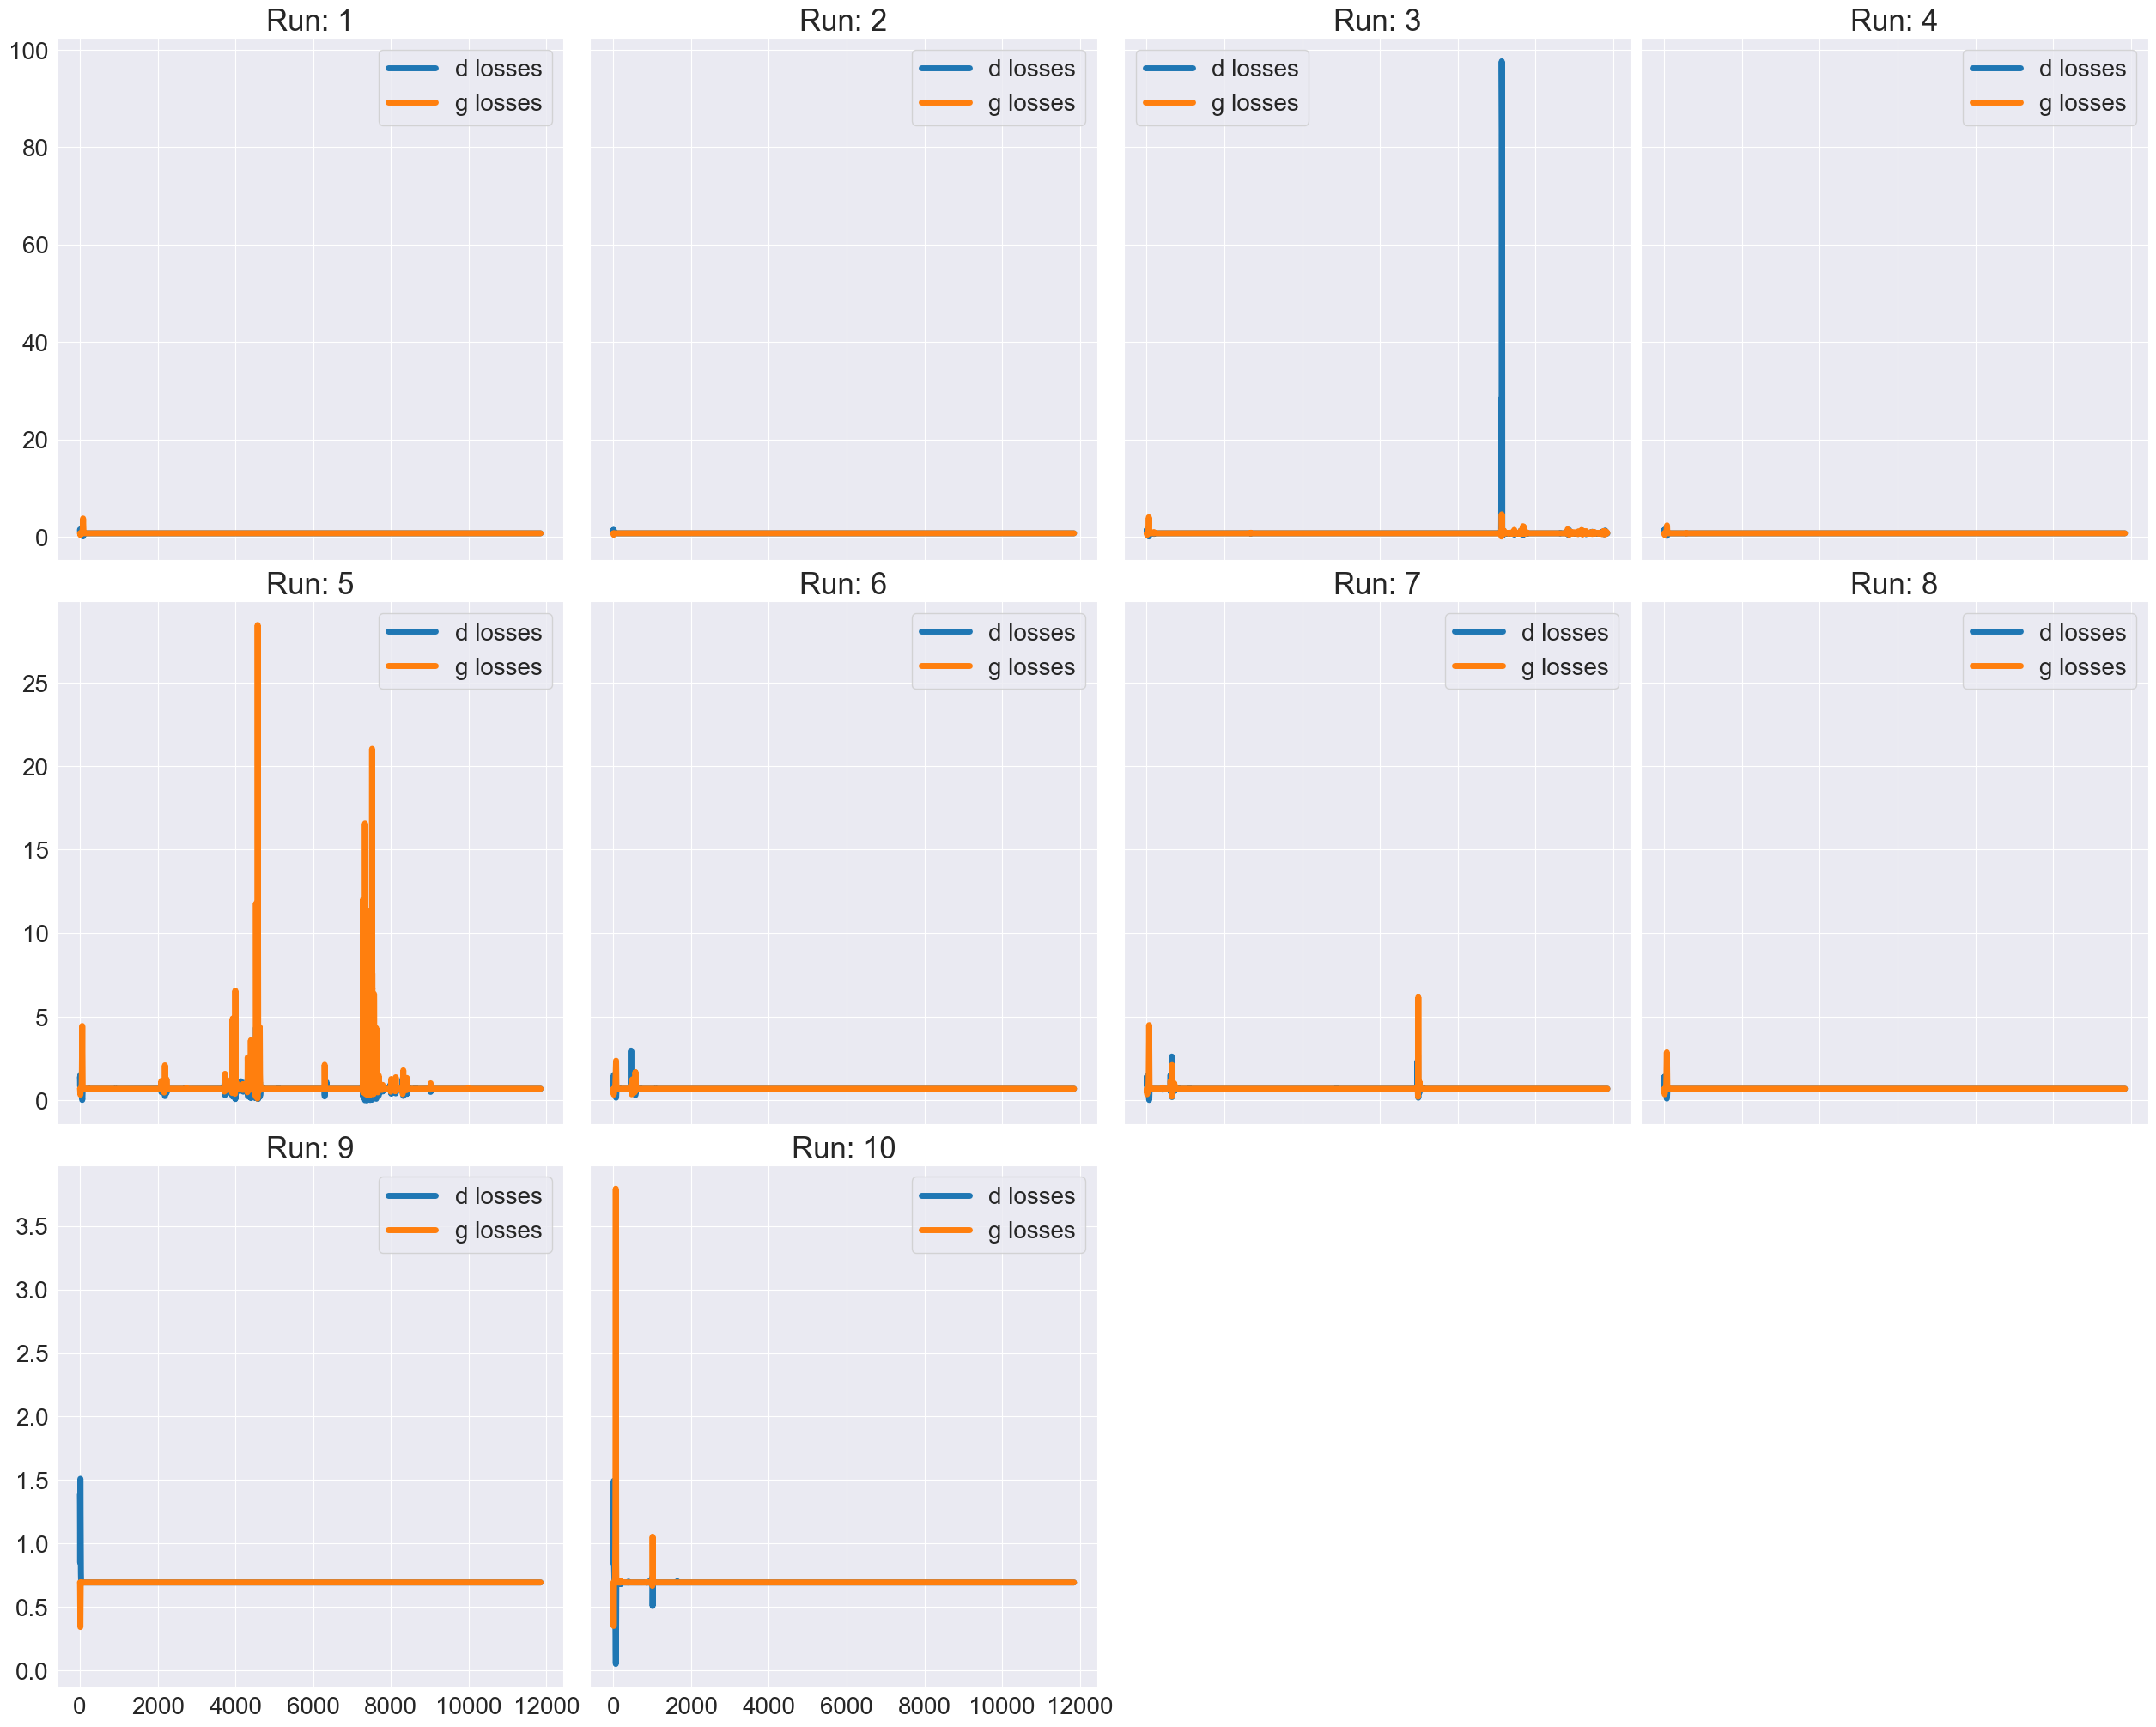

In [55]:
fig, ax = plt.subplots(3,4, figsize=(25,20), sharey='row', sharex='col', layout='constrained')
for i in range(len(res_df)):
    plot_run(res_df.iloc[i,2], f"Run: {res_df.iloc[i, 1]}", ax[i//4,i%4])
fig.delaxes(ax[2,2])
fig.delaxes(ax[2,3])
plt.show()